In [1]:
import matplotlib.pyplot as plt

from z3 import *
import numpy


In [2]:
# Definindo os parâmetros que podem ser editados de acordo com a necessidade
num_rows = 4       # Número de "linhas" ou grupos de coordenadas no eixo X
num_columns = 5   # Número de colunas de coordenadas no eixo Y
x_step = 2         # Distância entre as "linhas" no eixo X
x_offset = 3       # Deslocamento (offset) inicial no eixo X
y_offset = 1       # Deslocamento (offset) inicial no eixo Y

# Lista para armazenar todas as coordenadas do armazém
warehouse = []

# Criação das coordenadas do armazém
for i in range(num_rows):
    # 'i' representa cada linha de coordenadas que será criada
    for j in range(num_columns):
        # 'j' representa cada coluna na linha correspondente
        x = x_step * i + x_offset  # Cálculo da coordenada X
        y = j + y_offset           # Cálculo da coordenada Y
        warehouse.append((x, y))   # Adiciona a tupla (x, y) na lista

# Exibe a lista de coordenadas
print("Coordenadas do armazém:", warehouse)

# Definição da posição inicial do drone, pode ser alterada conforme necessidade
drone = (0, 0)
print("Posição inicial do drone:", drone)


Coordenadas do armazém: [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5)]
Posição inicial do drone: (0, 0)


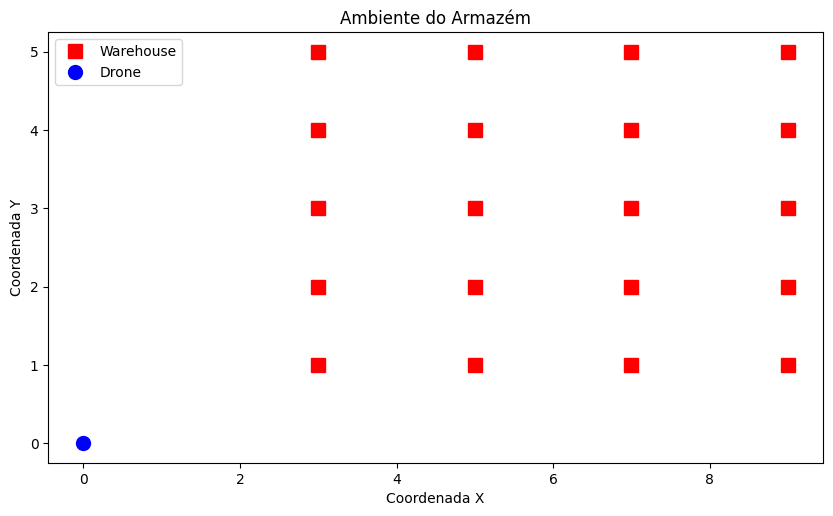

In [3]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot dos pontos do armazém
ax.plot(
    [x for x, y in warehouse],
    [y for x, y in warehouse],
    'rs',
    markersize=10,
    label='Warehouse'
)

# Plot da posição do drone
ax.plot(drone[0], drone[1], 'bo', markersize=10, label='Drone')

# Adiciona título e rótulos nos eixos
ax.set_title('Ambiente do Armazém')
ax.set_xlabel('Coordenada X')
ax.set_ylabel('Coordenada Y')

# Define a proporção igual para os eixos
ax.set_aspect('equal')

# Exibe a legenda
ax.legend()

plt.show()

Solução encontrada com 32 timesteps mínimos:

Trajetória do Drone:
Passo 0: Posição (0, 0), Bateria 100
Passo 1: Posição (1, 1), Bateria 97
Passo 2: Posição (2, 2), Bateria 94
Passo 3: Posição (3, 3), Bateria 91
Passo 4: Posição (3, 4), Bateria 89
Passo 5: Posição (3, 5), Bateria 87
Passo 6: Posição (4, 6), Bateria 84
Passo 7: Posição (5, 5), Bateria 81
Passo 8: Posição (6, 4), Bateria 78
Passo 9: Posição (7, 4), Bateria 76
Passo 10: Posição (7, 3), Bateria 74
Passo 11: Posição (7, 2), Bateria 72
Passo 12: Posição (7, 1), Bateria 70
Passo 13: Posição (8, 2), Bateria 67
Passo 14: Posição (9, 1), Bateria 64
Passo 15: Posição (9, 2), Bateria 62
Passo 16: Posição (9, 3), Bateria 60
Passo 17: Posição (9, 4), Bateria 58
Passo 18: Posição (9, 5), Bateria 56
Passo 19: Posição (8, 6), Bateria 53
Passo 20: Posição (7, 5), Bateria 50
Passo 21: Posição (6, 4), Bateria 47
Passo 22: Posição (5, 4), Bateria 45
Passo 23: Posição (5, 3), Bateria 43
Passo 24: Posição (5, 2), Bateria 41
Passo 25: Posição

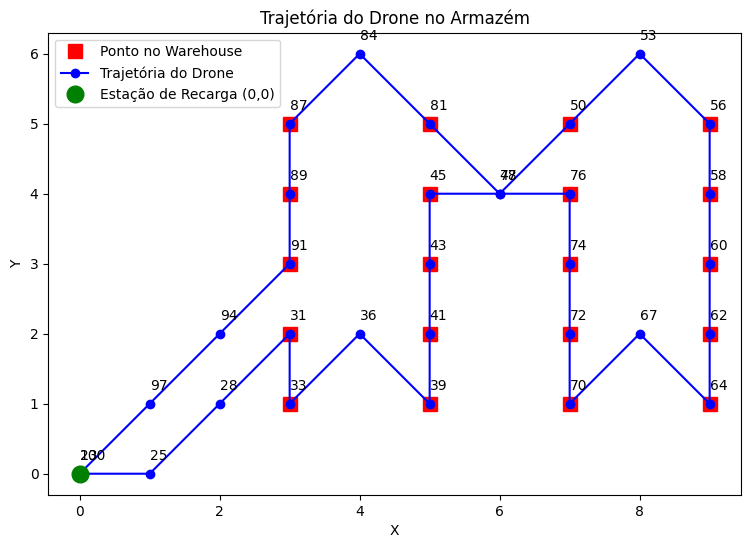

In [4]:
def solve_with_min_timesteps(max_timesteps, bmax, gridx, gridy, warehouse):
    for timesteps in range(1, max_timesteps + 1):
        s = Solver()

        # Declaração das variáveis para cada timestep
        PGx = [Int(f'pgx_{k}') for k in range(timesteps)]
        PGy = [Int(f'pgy_{k}') for k in range(timesteps)]
        Bat = [Int(f'bat_{k}') for k in range(timesteps)]

        # Restrições de limites para as variáveis
        for b in Bat:
            s.add(And(b >= 1, b <= bmax))
        for x in PGx:
            s.add(And(x >= 0, x <= gridx))
        for y in PGy:
            s.add(And(y >= 0, y <= gridy))

        # Condições iniciais
        s.add(PGx[0] == 0)
        s.add(PGy[0] == 0)
        s.add(Bat[0] == bmax)

        # Restrições de movimento e consumo de bateria
        for k in range(1, timesteps):
            s.add(Or(PGx[k] == PGx[k-1] + 1, PGx[k] == PGx[k-1] - 1, PGx[k] == PGx[k-1]))
            s.add(Or(PGy[k] == PGy[k-1] + 1, PGy[k] == PGy[k-1] - 1, PGy[k] == PGy[k-1]))
            
            # Impede que o drone permaneça na mesma posição
            s.add(Not(And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1])))
            
            s.add(If(
                Or(
                    And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1] + 1),
                    And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1] - 1),
                    And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1] - 1),
                    And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1] + 1)
                ),
                Bat[k] == Bat[k-1] - 3,
                If(
                    Or(
                        And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1]),
                        And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1]),
                        And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1] - 1),
                        And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1] + 1)
                    ),
                    Bat[k] == Bat[k-1] - 2,
                    Bat[k] == Bat[k-1]
                )
            ))


        # Cada ponto no warehouse deve ser visitado em algum timestep
        for (x, y) in warehouse:
            s.add(Or([And(PGx[k] == x, PGy[k] == y) for k in range(timesteps)]))

        # Adicionando restrição para que, no último timestep, o drone retorne ao ponto inicial (0,0)
        s.add(PGx[timesteps - 1] == 0)
        s.add(PGy[timesteps - 1] == 0)

        if s.check() == sat:
            m = s.model()
            print("Solução encontrada com", timesteps, "timesteps mínimos:")
            return m, timesteps, PGx, PGy, Bat

    print("Nenhuma solução encontrada até", max_timesteps, "timesteps.")
    return None, None, None, None, None

# Parâmetros do problema
max_timesteps = 100  # Limite superior para a busca de timesteps
bmax = 100
gridx = 9
gridy = 10

# Resolver o problema e obter o modelo e o número de timesteps mínimo
model, timesteps, PGx, PGy, Bat = solve_with_min_timesteps(max_timesteps, bmax, gridx, gridy, warehouse)

if model:
    # Extraindo os valores do modelo
    pgx_values = [model.evaluate(PGx[k]).as_long() for k in range(timesteps)]
    pgy_values = [model.evaluate(PGy[k]).as_long() for k in range(timesteps)]
    bat_values = [model.evaluate(Bat[k]).as_long() for k in range(timesteps)]

    # Exibindo os resultados
    print("\nTrajetória do Drone:")
    for t in range(timesteps):
        print(f"Passo {t}: Posição ({pgx_values[t]}, {pgy_values[t]}), Bateria {bat_values[t]}")

    # Visualização da trajetória
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plotando os pontos do warehouse
    for i, (x, y) in enumerate(warehouse):
        if i == 0:
            ax.plot(x, y, 'rs', markersize=10, label="Ponto no Warehouse")
        else:
            ax.plot(x, y, 'rs', markersize=10)

    # Plotando a trajetória do drone
    ax.plot(pgx_values, pgy_values, 'b-o', label="Trajetória do Drone")
    ax.plot(0, 0, 'go', markersize=12, label="Estação de Recarga (0,0)")

    # Adicionando a quantidade de bateria ao lado de cada ponto da trajetória
    for i in range(timesteps):
        ax.text(pgx_values[i], pgy_values[i] + 0.2, f'{bat_values[i]}', fontsize=10)

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Trajetória do Drone no Armazém")
    plt.legend()
    ax.set_aspect('equal')
    plt.show()
